## Inverse Problem - Supervised Model

Habiendo encontrado la dimensión mínima necesaria -para reconstruir las firmas polarimétricas- del espacio latente, nos disponemos a resolver el problema inverso utilizando los variables del espacio latente como predictoras.

La idea es generar firmas etiquetadas variando un solo parámetro físico -por ejemplo la constante dieléctrica-, "pasarlas" por un encoder previamente entrenado para generar variables predictivas. Luego utilizar dichas variables, junto con su etiqueta para entrenar un modelo supervisado y así poder predecir variables biofísicas a partir de firmas polarimétricas.

In [1]:
import json
import os
import pickle as pkl

import numpy as np
import pandas as pd
import tqdm 
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

from deep_scattering_models.data.create_data import make_labeled_data ,save_data, load_data
from deep_scattering_models.models.convolutional_autoencoder import load_cae_model
from deep_scattering_models.models.select_model import load_configuration
from deep_scattering_models.models.model_wrappers import build_cae_architecture
from deep_scattering_models.features.preprocess_data import RScaler, to_dB, remove_outliers
from deep_scattering_models.visualization.visualize import (plot_polarization_signature,
                                                            plot_histogram)

2023-01-11 15:45:56.492976: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-11 15:45:58.244907: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.2/lib64:
2023-01-11 15:45:58.245029: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.2/lib64:
2023-01-11 15:45:58.245036: W tensorflow/compiler/tf2tensorrt/utils/py_uti

### 1. Firmas etiquetadas y preprocesamiento

Genero datos sampleando la constante dieléctrica de la $1^{er}$ superficie de una distribución plana en el intervalo $(3, 38]$.

In [2]:
# Numero de experimentos e intervalo de sampleo
realizations = 5000
epsilon_interval = (3, 38)

# Genero y guardo los datos
#X_raw, y_raw = make_labeled_data(realizations, epsilon_interval)

src_dir = os.path.normpath(os.getcwd() + "../..")
data_dir = os.path.join(src_dir, "data/spm/raw")
file_path = os.path.join(data_dir, "spm_labeled_signatures.pkl")

#with open(file_path, "wb") as file_:
#    pkl.dump((X_raw, y_raw), file_)    

Procesamos las firmas para poder introducirlas en el modelo no supervisado y generar las variables predictoras (outputs de las unidadesd el espacio latente de CAE). Comenzamos removiendo outliers y pasando los datos a dB:

In [ ]:
X_dB = to_dB(X_raw)
print(f"Muestras luego de remover outliers: {X_dB.shape[0]}")
print(f"Valor máximo de potencia: {X_dB.max()}")
print(f"Valor mínimo de potencia: {X_dB.min()}")

<AxesSubplot:title={'center':'Polarization Signature values distribution'}, xlabel='$\\sigma(\\psi, \\chi)$', ylabel='Count'>

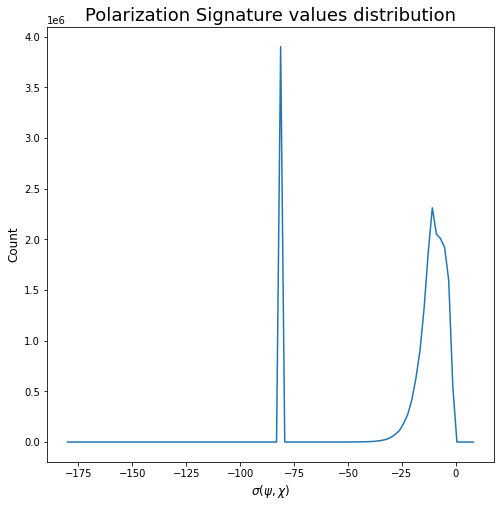

In [8]:
plot_histogram(X_dB, hist_kw={"range":(-180, 10)})

Separamos en conjuntos de entrenamiento y testeo, y normalizamos.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X_dB, 
    y_raw, 
    random_state=123, 
    test_size=.2
    )

print(f"Tamaño de los datos de entrenamiento: {X_train.shape=} {y_train.shape=}")
print(f"Tamaño de los datos de testeo: {X_test.shape=} {y_test.shape=}")

Tamaño de los datos de entrenamiento: X_train.shape=(4000, 45, 90) y_train.shape=(4000,)
Tamaño de los datos de testeo: X_test.shape=(1000, 45, 90) y_test.shape=(1000,)


In [13]:
scaler = RScaler().fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Conjunto de entrenamiento: mean={np.mean(X_train_scaled)}, dev={np.std(X_train_scaled)}")
print(f"Conjunto de testeo: mean={np.mean(X_test_scaled)}, dev={np.std(X_test_scaled)}")

Conjunto de entrenamiento: mean=-0.26058178645306107, dev=2.1320942578326467
Conjunto de testeo: mean=-0.2609004735531145, dev=2.1190753004773795


Tomemos algún ejemplo al azar del conjunto de entrenamiento y visualicémoslo

Text(0.5, 1.0, '$\\sigma(\\psi, \\chi)$ --- $\\epsilon$ = 33.414')

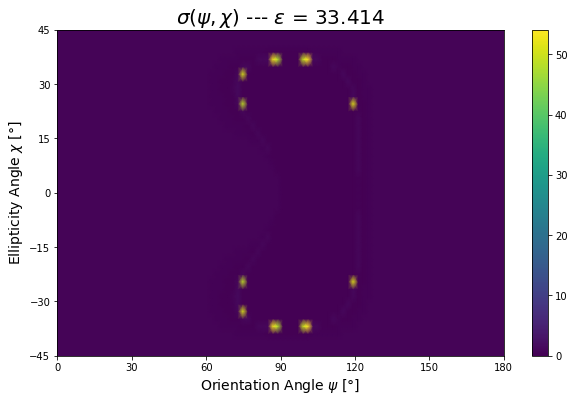

In [38]:
# Elegimos ana firma al azar
rng = np.random.default_rng()
rnd_index = rng.integers(X_train_scaled.shape[0])
rnd_signature = X_train_scaled[rnd_index, :, :]

# Ploteamos
ax = plt.gca()
plot_polarization_signature(rnd_signature, ax=ax)
ax.set_title(f"$\sigma(\psi, \chi)$ --- $\epsilon$ = {y_train[rnd_index]:.3f}", fontsize = 20)

Veamos un histograma de los conjuntos de entrenamiento y testeo

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

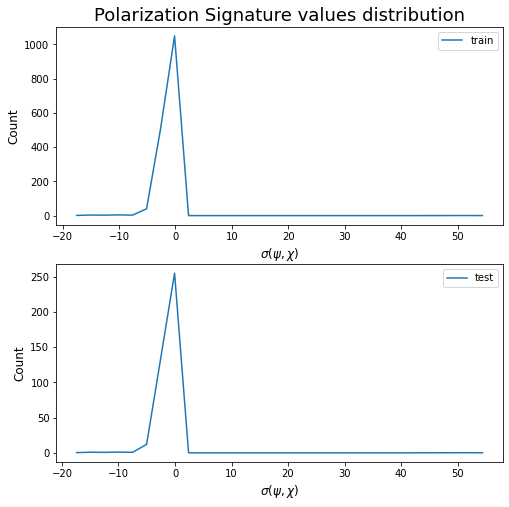

In [30]:
# Rango de valores válidos para los histogramas
train_range = np.min(X_train_scaled), np.max(X_train_scaled) 
test_range = np.min(X_test_scaled), np.max(X_test_scaled)

fig, ax1 = plt.subplots(2, 1, figsize=(20, 10))
plot_histogram(
    X_train_scaled, 
    ax=ax1[0], 
    n_bins=30,
    hist_kw={'range' : train_range, 'density' : True}, 
    plot_kw={'label' : 'train'}
    )
plot_histogram(
    X_test_scaled, 
    ax=ax1[1],
    n_bins=30, 
    hist_kw={'range' : test_range, 'density' : True}, 
    plot_kw={'label' : 'test'}
    )

ax1[1].set_title('')
for ax in ax1:
    ax.legend()

plt.tight_layout   

### 2.0 Variables del Latent Space

Pasamos los datos preprocesados por el modelo obtenido en 5.0, con el número mínimo de unidades en el espacio latente que reconstruyen las firmas. Para ello cargamos el modelo entrenado y lo usamos para transformar nuestro dataset.

In [3]:
with open(file_path, "rb") as file_:
    X_raw, y_raw = pkl.load(file_) 

cae_configuration = load_configuration("model_architecture_spm.json")
config_keys = ('conv_layers_config', 'dense_layers_config')

configuration = {keys : cae_configuration[keys] for keys in config_keys}
configuration.update({"latent_dimension" : 3})

print(configuration)

FileNotFoundError: [Errno 2] No such file or directory: '/home/jotavecorta/proyects/DeepScatteringModels/data/spm/raw/spm_labeled_signatures.pkl'

In [4]:
model, configuration = load_cae_model(name="final_cae")

OSError: No file or directory found at /home/jotavecorta/proyects/DeepScatteringModels/models/final_cae_model_weights